In [7]:
import sys
import numpy as np
from matplotlib import pyplot as plt

In [8]:
class CoordinateProcess:
    def __init__(self, num_cities=20, min_coord=1, max_coord=5):
        self.num_cities = num_cities  # 要创建的坐标点的数量
        self.min_coord = min_coord  # 最大坐标范围
        self.max_coord = max_coord  # 最小坐标范围

        self.coordinate = self.generate_coordnte()  # 生成随机坐标点
        self.distance_matrix = self.calculate_distance_matrix()  # 各坐标点之间的距离矩阵

    def generate_coordnte(self):
        return np.random.randint(self.min_coord, self.max_coord, size=(self.num_cities, 2))

    def calculate_distance_matrix(self):
        d_mtrx = np.zeros((self.coordinate.shape[0], self.coordinate.shape[0]))
        for indexi in range(d_mtrx.shape[0]):
            for indexj in range(d_mtrx.shape[0]):
                if indexi == indexj:
                    continue
                d_mtrx[indexi][indexj] = np.sqrt(np.power(self.coordinate[indexi] -
                                                          self.coordinate[indexj], 2).sum())
        return d_mtrx

    def plot_cities(self):
        plt.title("City Coordinate")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.scatter(self.coordinate[:, 0], self.coordinate[:, 1])
        for i in range(self.coordinate.shape[0]):
            plt.annotate(str(i), xy=(self.coordinate[i][0], self.coordinate[i][1]))
        plt.show() 

In [13]:
class AntColony:
    def __init__(self, city_coord, distance_matrix, ant_size=8, info_alpha=1,
                 heu_beta=5, phe_decay=0.1, phe_amount=1, max_iter=100, ant_model='acs'):
        self.city_index = np.array([i for i in range(len(city_coord))])  # 城市索引

        self.city_coord = city_coord  # 坐标矩阵
        self.distance_matrix = distance_matrix  # 距离矩阵
        self.max_iter = max_iter  # 最大迭代次数

        self.ant_size = ant_size  # 蚁群大小
        self.info_alpha = info_alpha  # 信息素重要度因子
        self.phe_beta = heu_beta  # 启发函数重要度因子
        self.phe_decay = phe_decay  # 信息素衰减系数
        self.phe_amount = phe_amount  # 蚂蚁信息素散布量
        self.ant_model = ant_model

        self.phe_matrix = np.ones(self.distance_matrix.shape)  # 道路残留信息素矩阵,初始化为1

        self.ant_pos = []
        self.ant_city_allow = [[]]
        self.ant_path_collector = [[]]
        self.ant_plen_collector = []
        # self.ant_init()

        self.best_path = []
        self.best_path_length = sys.maxsize
        self.mean_len_record = []
        self.best_len_record = []

    def ant_init(self):
        '''
        初始化蚂蚁位置，禁忌表，路径记录表，路径长度表
        :return:
        '''
        self.ant_pos = [self.city_index[np.random.randint(0, len(self.city_coord))] for _ in range(self.ant_size)]
        self.ant_city_allow = [[city_index for city_index in self.city_index if city_index != self.ant_pos[i]] for i in range(self.ant_size)]
        self.ant_path_collector = [[self.ant_pos[i]] for i in range(self.ant_size)]
        self.ant_plen_collector = [0 for _ in range(self.ant_size)]

    def calculate_visitprob(self, ant_index, city_from, city_to):
        '''
        # 计算蚂蚁ant_index从城市city_from到城市city_to的概率,取决于进禁忌表，信息素矩阵以及距离矩阵
        :param ant_index:
        :param city_from:
        :param city_to:
        :return:
        '''

        top = np.power(self.phe_matrix[city_from][city_to], self.info_alpha) * \
              np.power(1/self.distance_matrix[city_from][city_to], self.phe_beta)
        down = np.array([np.power(self.phe_matrix[city_from][city_index], self.info_alpha) *
                         np.power(1/self.distance_matrix[city_from][city_index], self.phe_beta)
                         for city_index in self.ant_city_allow[ant_index]]).sum()
        return top/down

    def roulette_selection(self, ant_index):  # 轮盘对赌选择法确定蚂蚁去往哪个城市
        '''
        :param ant_index: 输入蚂蚁index
        :return: 城市index
        '''
        ant_visit_prob = np.array([self.calculate_visitprob(ant_index, self.ant_pos[ant_index], city_to)
                                   for city_to in self.ant_city_allow[ant_index]])
        sum_fits = ant_visit_prob.sum()
        rnd_point = np.random.uniform(0, sum_fits)
        accumulator = 0.0
        for index, val in enumerate(ant_visit_prob):
            accumulator += val
            if accumulator >= rnd_point:
                return self.ant_city_allow[ant_index][index]

    def calculate_delta_phe(self):
        '''
        :return: delta 蚂蚁散布的信息素矩阵
        '''
        phe_dis_matrix = np.zeros(shape=self.phe_matrix.shape)
        if self.ant_model == 'aqs' or self.ant_model == 'ads':
            for ant_index in range(self.ant_size):
                city_from = self.ant_path_collector[ant_index][-2]
                city_to = self.ant_path_collector[ant_index][-1]
                if self.ant_model == 'aqs':
                    phe_dis_matrix[city_from][city_to] += self.phe_amount/self.distance_matrix[city_from][city_to]
                else:
                    phe_dis_matrix[city_from][city_to] += self.phe_amount
        if self.ant_model == 'acs':
            for ant_index in range(self.ant_size):
                dis_phe_amount = self.phe_amount/self.ant_plen_collector[ant_index]
                for path_index in range(len(self.city_coord) - 1):
                    city_from = self.ant_path_collector[ant_index][path_index]
                    city_to = self.ant_path_collector[ant_index][path_index+1]
                    phe_dis_matrix[city_from][city_to] += dis_phe_amount
        return phe_dis_matrix

    def ant_visit(self):
        '''
        一次搜寻，所有蚂蚁都完成对所有城市的一次访问
        :return:
        '''
        while True:
            if len(self.ant_path_collector[-1]) >= len(self.city_coord):
                break
            else:
                # 所有蚂蚁都选择一个城市
                for ant_index in range(self.ant_size):
                    # 选择一个城市
                    selected_city = self.roulette_selection(ant_index)
                    # 更新位置, 添加路径
                    self.ant_pos[ant_index] = selected_city
                    self.ant_path_collector[ant_index].append(selected_city)
                    # 从禁忌表中删除此城市
                    self.ant_city_allow[ant_index].remove(selected_city)
                if self.ant_model in ['aqs', 'ads']:
                    phe_dis_matrix = self.calculate_delta_phe()
                    #  所有蚂蚁都向前搜索一步之后，更新这些道路上的信息素
                    self.phe_matrix += phe_dis_matrix

    def is_stop(self, iter_round):
        return iter_round >= self.max_iter

    def update_path_length(self):
        '''
        更新路径长度记录
        :return:
        '''
        for ant_index in range(self.ant_size):
            path_length = 0
            for path_index in range(len(self.city_coord) - 1):
                city_from = self.ant_path_collector[ant_index][path_index]
                city_to = self.ant_path_collector[ant_index][path_index + 1]
                path_length += self.distance_matrix[city_from][city_to]
            self.ant_plen_collector[ant_index] = \
                path_length + self.distance_matrix[self.ant_path_collector[ant_index][-1]][self.ant_path_collector[ant_index][0]]

    def update_road_phe(self):
        self.phe_matrix = (1 - self.phe_decay) * self.phe_matrix + self.calculate_delta_phe()

    def update_best(self):
        length_array = np.array(self.ant_plen_collector)
        if self.best_path_length > length_array.min():
            self.best_path_length = length_array.min()
            self.best_path = self.ant_path_collector[np.argmin(length_array)]
            self.best_path.append(self.best_path[0])
        
    def plot_path(self):
        plt.title("City Coordinate_AntColony")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.scatter(self.city_coord[:, 0], self.city_coord[:, 1])
        for i in range(self.city_coord.shape[0]):
            plt.annotate(str(i), xy=(self.city_coord[i][0],
                                     self.city_coord[i][1]
                                     ))
        line_x = [self.city_coord[i,0] for i in self.best_path]
        line_y = [self.city_coord[i,1] for i in self.best_path]
        plt.annotate('S_E', xy=(line_x[0],line_y[0]))
        plt.plot(line_x, line_y)
        plt.show()
    
    def plot_iter_info(self):
        '''
        :return: 迭代过程个体最优均值和全局最优指标绘制
        '''
        x = [iter_i for iter_i in range(1, self.max_iter + 1)]
        y_list = [self.mean_len_record, self.best_len_record]
        y_lable_list = ['mean_path_length', 'best_length']
        for y_index in range(len(y_list)):
            plt.title(y_lable_list[y_index] + '_AntColony')
            plt.plot(x, y_list[y_index], label=y_lable_list[y_index])
            plt.xlabel(r'iter_round')
            plt.ylabel(y_lable_list[y_index])
            plt.show()

    def ant_engine(self):  # 主运行程序
        iter_round = 0
        while True:
            if not self.is_stop(iter_round):
                # 初始化蚂蚁位置
                self.ant_init()
                # 创建解空间
                self.ant_visit()
                # 计算路径的长度
                self.update_path_length()
                # 更新最优解
                self.update_best()
                # 更新道路信息素
                self.update_road_phe()
                self.mean_len_record.append(np.array(self.ant_plen_collector).mean())
                self.best_len_record.append(self.best_path_length)
                iter_round += 1
                if iter_round % 10 == 0:
                    print("ant_iter_round:",iter_round)
                continue
            break
        print('Ant Cololny:')
        print('best path:', self.best_path)
        print('length of best path:',self.best_path_length)
        return self.plot_path(), self.plot_iter_info()

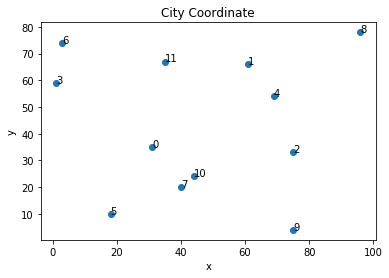

In [14]:
# 点坐标、距离矩阵
coord_generator = CoordinateProcess(num_cities=12, min_coord=1, max_coord=100)
coord_generator.plot_cities()
city_coord = coord_generator.coordinate
distance_matrix = coord_generator.distance_matrix

iter_round: 10
iter_round: 20
iter_round: 30
iter_round: 40
iter_round: 50
iter_round: 60
iter_round: 70
iter_round: 80
iter_round: 90
iter_round: 100
Ant Cololny:
best path: [1, 11, 6, 3, 0, 5, 7, 10, 9, 2, 4, 8, 1]
length of best path: 331.1851924453565


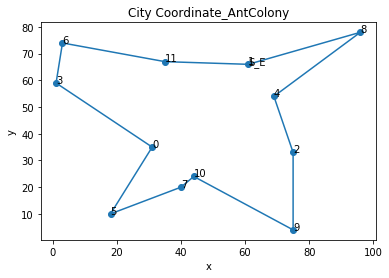

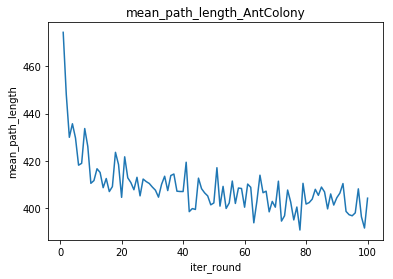

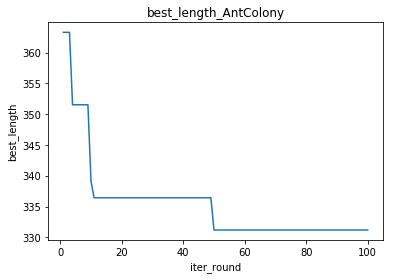

(None, None)

In [15]:
ant_test = AntColony(city_coord,distance_matrix,ant_size=30, info_alpha=1,
                     heu_beta=2, phe_decay=0.1, phe_amount=10, max_iter=100, ant_model='aqs')
ant_test.ant_engine()
